Model Can Walk
==============



## Goal



The goal of this notebook is to make plots for Figure 2 of the paper. Namely:

-   An example trajectory
-   Phase angle plot comparisons
-   Angle error
-   Phase coupling within a leg
-   Phase coupling across legs
-   Step frequency distributions
-   Demo videos

The network should be set up so that running it from top to bottom makes all the figure sublayouts.



## Setup



In [1]:
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, trange
import pandas as pd
from scipy import signal, stats
import pickle
from glob import glob

In [2]:
import sys
project_path = "/home/lili/research/tuthill/layered-walking"
data_path = '/home/lili/data/tuthill/models/sls_runs'
sys.path.append(project_path)
from tools.angle_functions import anglesTG as angle_names_1leg
from tools.angle_functions import legs
from tools.angle_functions import make_fly_video, angles_to_pose_names
from tools.trajgen_tools import WalkingData

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = (7.5, 2)

In [4]:
xvals = np.linspace(-np.pi, np.pi)
def get_phase(ang):
    m = np.median(ang, axis=0)
    s = np.std(ang, axis=0)
    s[s == 0] = 1
    dm = (ang - m) / s
    phase = np.arctan2(-dm[:,1], dm[:,0])
    return phase

def phase_align_poly(ang, extra=None, order=5):
    topredict = ang
    if extra is not None:
        topredict = np.hstack([ang, extra])
    means = np.full((len(xvals), topredict.shape[1]), np.nan)
    stds = np.full((len(xvals), topredict.shape[1]), np.nan)
    if len(ang) < 50: # not enough data
        return means, stds
    phase = get_phase(ang)
    # pcs = np.vstack([np.cos(phase), np.sin(phase)]).T
    b = np.vstack([np.cos(i * phase + j) for i in range(order) for j in [0, np.pi/2]]).T
    xcs = np.vstack([np.cos(i * xvals + j) for i in range(order) for j in [0, np.pi/2]]).T
    for i in range(topredict.shape[1]):
        cc = np.isfinite(topredict[:,i])
        model = sm.OLS(topredict[cc,i], b[cc]).fit()
        means[:,i] = model.predict(xcs)
        s, upper,lower = wls_prediction_std(model, xcs)
        stds[:,i] = s
    return means, stds

In [5]:
# list(d.keys())

In [6]:
# fname_pat = os.path.join(data_path, 'delays_stats_subang_v2_actuate_gaussian_*.npz')
fname_pat = os.path.join(data_path, 'stats_subang_v9_nodist_*.pkl')
fnames = sorted(glob(fname_pat))

conditions = []
angles = []
derivs = []
accels = []
phasesTG = []

for fname in tqdm(fnames, ncols=70):
    # d = np.load(fname, allow_pickle=True)
    with open(fname, 'rb') as f:
        d = pickle.load(f)

    angle_names = d['angleNames'][0]

    for i, cond in enumerate(d['conditions']):
        ang = d['angle'][i]
        deriv = signal.savgol_filter(ang, 5, 2, deriv=1, axis=0)
        accel = signal.savgol_filter(deriv, 5, 2, deriv=1, axis=0)
        conditions.append(cond)
        angles.append(ang)
        derivs.append(deriv)
        accels.append(accel)
        phasesTG.append(d['phaseTG'][i])

100%|█████████████████████████████████| 52/52 [00:03<00:00, 15.60it/s]


In [7]:
accels[0]

array([[ 0.11276215,  1.4998475 ,  2.4084078 , ..., -0.01207362,
         0.00592604, -0.12670231],
       [ 0.04416785,  1.27679536,  2.20302964, ..., -0.01255835,
         0.00919893, -0.12215865],
       [-0.02442644,  1.05374322,  1.99765148, ..., -0.01304308,
         0.01247181, -0.11761499],
       ...,
       [ 0.03699307,  0.0439054 , -0.08968198, ..., -0.13412065,
         0.06870487, -0.10270925],
       [ 0.0598091 ,  0.07240991, -0.05634409, ..., -0.15680284,
         0.07513222, -0.14503007],
       [ 0.08262512,  0.10091441, -0.02300619, ..., -0.17948503,
         0.08155956, -0.18735089]])

In [8]:
speeds = np.array([x['context'] for x in conditions])
angle_names = list(angle_names)

In [9]:
fname = '/home/lili/data/tuthill/models/models_sls/data_subang_5.pickle'
wd = WalkingData(fname)

In [10]:
wd.bout_context

array([[  4.246732  ,   0.7071299 ,   0.3955671 ],
       [  2.5441482 ,   3.387733  ,   1.0246041 ],
       [  2.3452914 ,  -0.44610858,  -0.20245193],
       ...,
       [  6.904698  ,   3.0903168 ,   3.0456958 ],
       [  5.8905787 ,  -4.7177234 ,   1.9700806 ],
       [  8.232974  , -12.293827  ,  -0.86852646]], dtype=float32)

In [11]:
fancy_angle_names = {
    'C_flex': 'femur-tibia\nflexion',
    'A_rot': 'coxa\nrotation',
    'A_abduct': 'body-coxa\nflexion',
    'B_flex': 'coxa-femur\nflexion',
    'B_rot': 'femur\nrotation'
}

## Figure 2



### Example time series



For the figure 2 part A, we'd like to have multiple example angles. Perhaps R1 femur-tibia flexion would be good to show, but also L2 femur rotation?
I'd like to have multiple traces for each angle, perhaps we could show with forward, rotation, and sideslip?

In this code, we could also make a supplementary figure with a more complete set of angles.



#### Real tracking



Parameters for both angles



In [12]:
plot_speeds = [[8, 0, 0], [10, 0, 0], [12, 0, 0]]

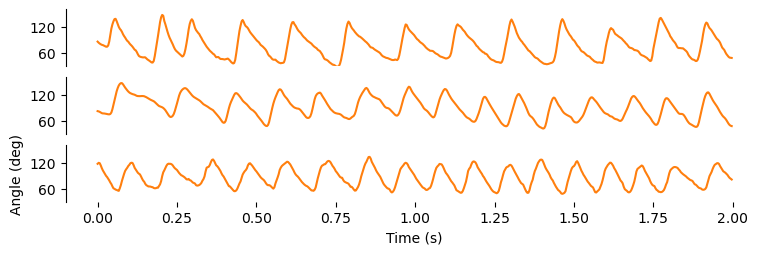

In [13]:
angname = 'C_flex'
leg = 'R1'
# ix_ang = angle_names_1leg.index(angname)
ix_ang = wd._angle_names[leg].index(leg + angname)
ix_leg = legs.index(leg)

plt.figure(figsize=(9, 2.5))
for i in range(len(plot_speeds)):
    plt.subplot(3, 1, i+1)
    ww = wd.get_bout(plot_speeds[i], offset=40)
    ang = ww['angles'][leg][:600, ix_ang]
    t = np.arange(len(ang))/300.0
    plt.plot(t, ang, color="#FF7F0E")
    plt.ylim(30, 160)
    plt.yticks([60, 120])
    if i != 2:
        plt.xticks(ticks=[])

sns.despine(bottom=True)

plt.ylabel("Angle (deg)")
plt.xlabel("Time (s)")
plt.savefig('plots/fig2A_trace_real_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

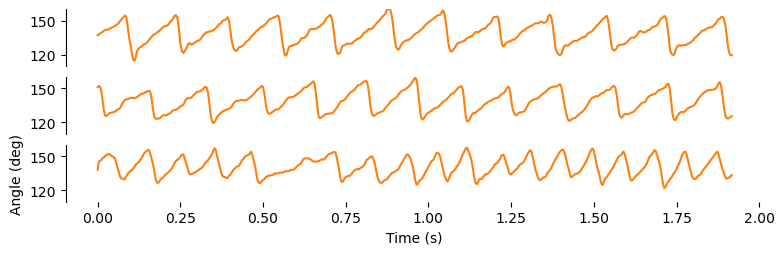

In [14]:
angname = 'B_rot'
leg = 'L2'
# ix_ang = angle_names_1leg.index(angname)
ix_ang = wd._angle_names[leg].index(leg + angname)
ix_leg = legs.index(leg)

plt.figure(figsize=(9, 2.5))
for i in range(len(plot_speeds)):
    plt.subplot(3, 1, i+1)
    ww = wd.get_bout(plot_speeds[i], offset=4)
    ang = ww['angles'][leg][:600, ix_ang].copy()
    t = np.arange(len(ang))/300.0
    ang[ang > 50] -= 360
    ang += 360
    plt.plot(t, ang, color="#FF7F0E")
    plt.ylim(110, 160)
    plt.yticks([120, 150])
    if i != 2:
        plt.xticks(ticks=[])

sns.despine(bottom=True)

plt.ylabel("Angle (deg)")
plt.xlabel("Time (s)")
plt.savefig('plots/fig2A_trace_real_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

#### Simulated plots



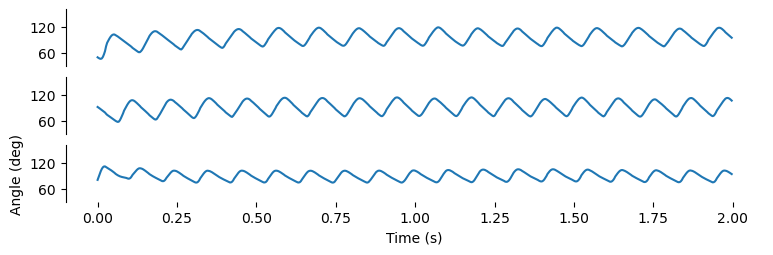

In [15]:
angname = 'C_flex'
leg = 'R1'
ix_ang = angle_names.index(leg + angname)

plt.figure(figsize=(9, 2.5))
for i in range(len(plot_speeds)):
    plt.subplot(3, 1, i+1)
    ixs = np.where(np.all(speeds == plot_speeds[i], axis=1))[0]
    ix_bout = ixs[0]
    ang = angles[ix_bout][:, ix_ang]
    t = np.arange(len(ang))/300.0
    plt.plot(t[:600], ang[:600])
    plt.ylim(30, 160)
    plt.yticks([60, 120])
    if i != 2:
        plt.xticks(ticks=[])

sns.despine(bottom=True)
plt.ylabel("Angle (deg)")
plt.xlabel("Time (s)")

plt.savefig('plots/fig2A_trace_simulated_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

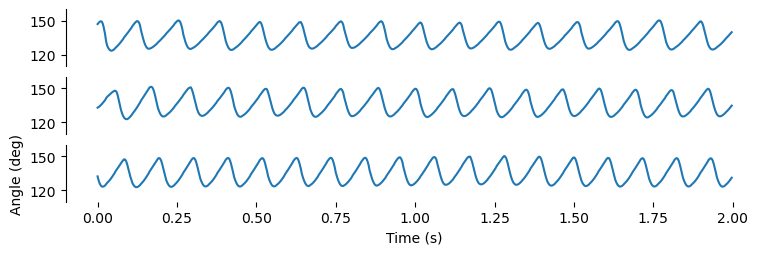

In [16]:
angname = 'B_rot'
leg = 'L2'
ix_ang = angle_names.index(leg + angname)

plt.figure(figsize=(9, 2.5))
for i in range(len(plot_speeds)):
    plt.subplot(3, 1, i+1)
    ixs = np.where(np.all(speeds == plot_speeds[i], axis=1))[0]
    ix_bout = ixs[0]
    ang = angles[ix_bout][:, ix_ang]
    t = np.arange(len(ang))/300.0
    plt.plot(t[:600], ang[:600])
    plt.ylim(110, 160)
    plt.yticks([120, 150])
    if i != 2:
        plt.xticks(ticks=[])

sns.despine(bottom=True)

plt.ylabel("Angle (deg)")
plt.xlabel("Time (s)")

plt.savefig('plots/fig2A_trace_simulated_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

### Videos for example series



Here, we make some videos corresponding to the example time series, for visualizing all of the angles at the same time.



In [17]:
video_speeds = [
    [8, 0, 0], [10, 0, 0], [12, 0, 0], [14, 0, 0],
    [12, -8, 0], [12, 8, 0],
    [12, 0, -4], [12, 0, 4]
]

In [18]:
def format_speed(speed):
    return '_'.join([str(x) for x in speed])

Simulated videos



In [19]:
for i, speed in enumerate(video_speeds):
    print(speed)
    ixs = np.where(np.all(speeds == speed, axis=1))[0]
    ix_bout = ixs[3]
    pose = angles_to_pose_names(angles[ix_bout], angle_names)
    make_fly_video(pose, 'vids/simulated_fly_{}.mp4'.format(format_speed(speed)))
plt.close('all')

[8, 0, 0]


100%|███████████████████████████████| 900/900 [00:20<00:00, 44.13it/s]


[10, 0, 0]


100%|███████████████████████████████| 900/900 [00:20<00:00, 44.19it/s]


[12, 0, 0]


100%|███████████████████████████████| 900/900 [00:19<00:00, 45.03it/s]


[14, 0, 0]


100%|███████████████████████████████| 900/900 [00:20<00:00, 43.96it/s]


[12, -8, 0]


100%|███████████████████████████████| 900/900 [00:20<00:00, 44.89it/s]


[12, 8, 0]


100%|███████████████████████████████| 900/900 [00:20<00:00, 43.90it/s]


[12, 0, -4]


100%|███████████████████████████████| 900/900 [00:20<00:00, 44.19it/s]


[12, 0, 4]


100%|███████████████████████████████| 900/900 [00:20<00:00, 44.15it/s]


In [20]:
for i, speed in enumerate(video_speeds):
    print(speed)
    ww = wd.get_bout(video_speeds[i], offset=0)
    out = []
    angnames = []
    for leg in legs:
        ang = ww['angles'][leg]
        out.append(ang)
        angnames.extend(wd._angle_names[leg])
    ang = np.hstack(out)
    pose = angles_to_pose_names(ang, angnames)
    make_fly_video(pose, 'vids/real_fly_{}.mp4'.format(format_speed(speed)))
plt.close('all')

[8, 0, 0]


100%|█████████████████████████████| 1416/1416 [00:32<00:00, 44.21it/s]


[10, 0, 0]


100%|███████████████████████████████| 600/600 [00:13<00:00, 44.40it/s]


[12, 0, 0]


100%|█████████████████████████████| 2160/2160 [00:48<00:00, 44.72it/s]


[14, 0, 0]


100%|███████████████████████████████| 600/600 [00:13<00:00, 43.83it/s]


[12, -8, 0]


100%|█████████████████████████████| 1920/1920 [00:43<00:00, 43.82it/s]


[12, 8, 0]


100%|███████████████████████████████| 528/528 [00:11<00:00, 45.81it/s]


[12, 0, -4]


100%|███████████████████████████████| 660/660 [00:15<00:00, 42.91it/s]


[12, 0, 4]


100%|███████████████████████████████| 960/960 [00:21<00:00, 44.05it/s]


### Phase angle plots



In this set, I'll plot some angles of phase vs angle

Load the simulated data



In [21]:
ds = []
for i in trange(len(speeds), ncols=70):
    for ix_ang, angname in enumerate(angle_names):
        leg = angname[:2]
        forward, rot, side = speeds[i]
        x = np.vstack([angles[i][:, ix_ang],
                       derivs[i][:, ix_ang]]).T
        c = np.all(np.isfinite(x), axis=1)
        x = x[c]
        means, stds = phase_align_poly(
            x, extra=accels[i][c, ix_ang, None])
        d = pd.DataFrame(np.hstack([xvals[:,None],means]),
                         columns=['phase', 'angle', 'deriv', 'accel'])
        d['speed_forward'] = forward
        d['speed_rotation'] = rot
        d['speed_side'] = side
        d['angle_name'] = angname[2:]
        d['leg'] = leg
        d['type'] = 'simulated'
        ds.append(d)
allangf = pd.concat(ds).reset_index(drop=True)

100%|█████████████████████████████| 1540/1540 [01:46<00:00, 14.39it/s]


Load the real data



In [22]:
ds = []
bnums = wd._get_minlen_bnums(400)
for i in trange(len(bnums), ncols=70):
    bnum = bnums[i]
    ww = wd.get_bnum(bnum)
    mean_speed = np.mean(ww['contexts'], axis=0)
    forward, rot, side = mean_speed
    for ix_leg, leg in enumerate(legs):
        for ix_ang, angname in enumerate(wd._angle_names[leg]):
            angs = ww['angles'][leg][:, ix_ang]
            drvs = ww['derivatives'][leg][:, ix_ang]
            acls = signal.savgol_filter(drvs, 5, 2, deriv=1)
            x = np.vstack([angs, drvs]).T
            c = np.all(np.isfinite(x), axis=1)
            x = x[c]
            means, stds = phase_align_poly(
                x, extra=acls[:,None])
            d = pd.DataFrame(np.hstack([xvals[:,None],means]),
                             columns=['phase', 'angle', 'deriv', 'accel'])
            d['speed_forward_raw'] = forward
            d['speed_rotation_raw'] = rot
            d['speed_side_raw'] = side
            d['angle_name'] = angname[2:]
            d['leg'] = leg
            d['bnum'] = bnum
            d['type'] = 'real'
            ds.append(d)
realangf = pd.concat(ds).reset_index(drop=True)

realangf['speed_forward'] = ((realangf['speed_forward_raw'] + 2) // 2) * 2
realangf['speed_rotation'] = ((realangf['speed_rotation_raw'] + 2) // 4) * 4
realangf['speed_side'] = ((realangf['speed_side_raw'] + 1) // 2) * 2

realangf['speed_forward'] = realangf['speed_forward'].astype('int')
realangf['speed_rotation'] = realangf['speed_rotation'].astype('int')
realangf['speed_side'] = realangf['speed_side'].astype('int')

100%|█████████████████████████████| 1254/1254 [01:45<00:00, 11.93it/s]


In [23]:
fullangf = pd.concat([allangf, realangf]).reset_index(drop=True)

In [24]:
fullangf['deriv_units'] = fullangf['deriv'] * 300.0
fullangf['accel_units'] = fullangf['accel'] * 300.0 * 300.0

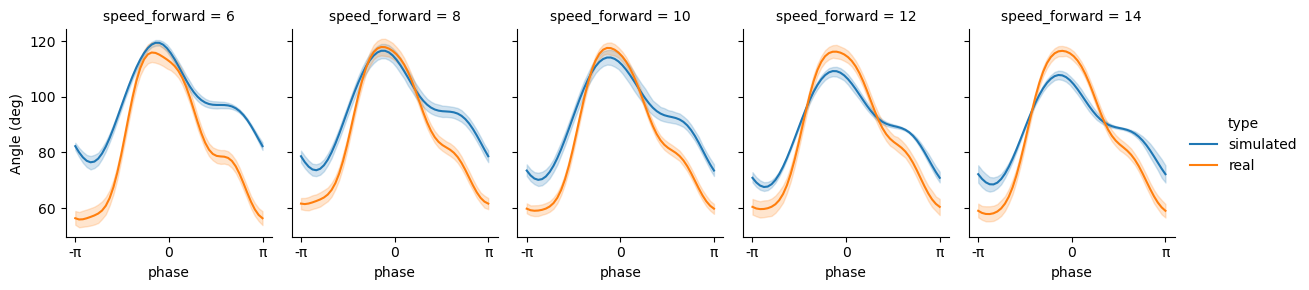

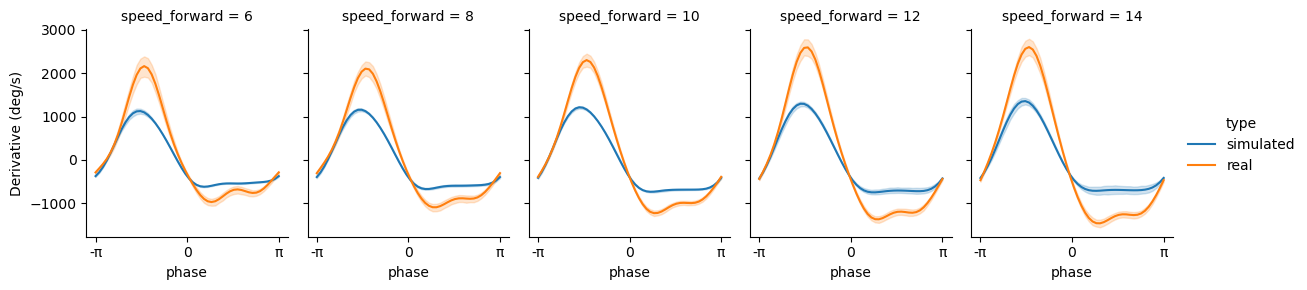

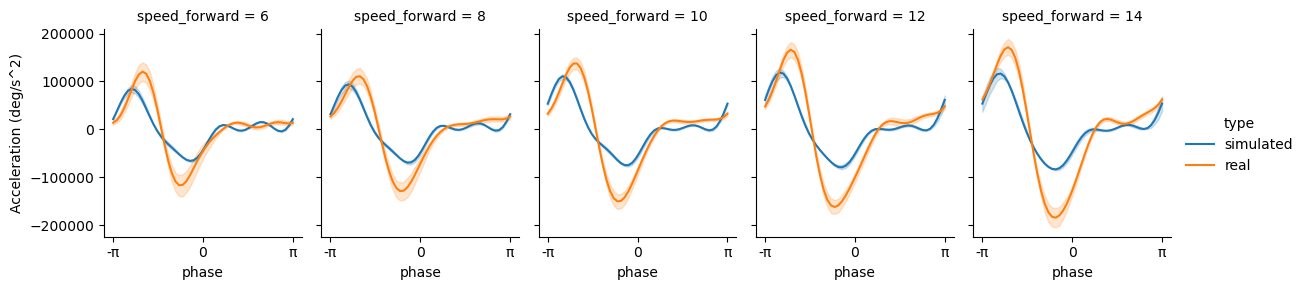

In [35]:
leg = 'R1'
angname = 'C_flex'

dd = fullangf
c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] > 5) & (dd['speed_forward'] < 15) \
    & (dd['angle_name'] == angname) & (dd['leg'] == leg)
g = sns.relplot(data=dd[c], x="phase", y="angle", hue="type",
                estimator=np.mean, err_style='band', errorbar=('ci', 95),
                col="speed_forward", kind="line", height=3, aspect=0.8)
g.set(ylabel="Angle (deg)")
g.set(xticks=[-np.pi, 0, np.pi], xticklabels=["-π", "0", "π"])
plt.savefig('plots/fig2B_phase_angle_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] > 5) & (dd['speed_forward'] < 15) \
    & (dd['angle_name'] == angname) & (dd['leg'] == leg)
g = sns.relplot(data=dd[c], x="phase", y="deriv_units", hue="type",
                estimator=np.mean, err_style='band', errorbar=('ci', 95),
                col="speed_forward", kind="line", height=3, aspect=0.8)
g.set(ylabel="Derivative (deg/s)")
g.set(xticks=[-np.pi, 0, np.pi], xticklabels=["-π", "0", "π"])
plt.savefig('plots/fig2B_phase_deriv_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] > 5) & (dd['speed_forward'] < 15) \
    & (dd['angle_name'] == angname) & (dd['leg'] == leg)
g = sns.relplot(data=dd[c], x="phase", y="accel_units", hue="type",
                estimator=np.mean, err_style='band', errorbar=('ci', 95),
                col="speed_forward", kind="line", height=3, aspect=0.8)
g.set(ylabel="Acceleration (deg/s^2)")
g.set(xticks=[-np.pi, 0, np.pi], xticklabels=["-π", "0", "π"])
plt.savefig('plots/fig2B_phase_accel_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

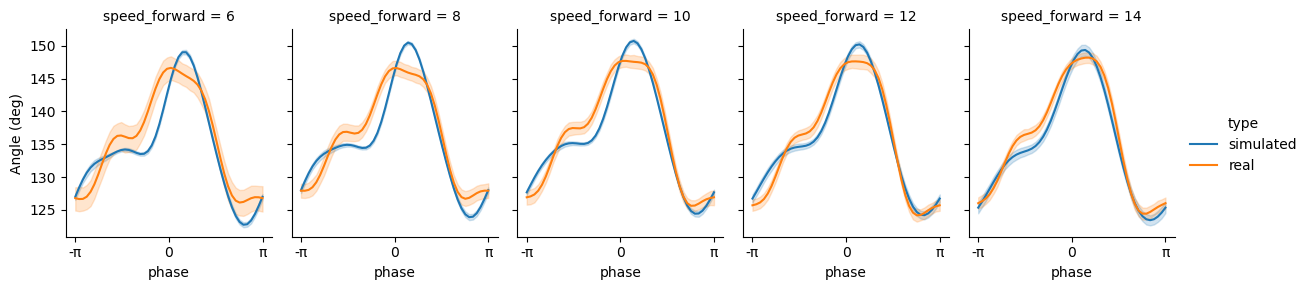

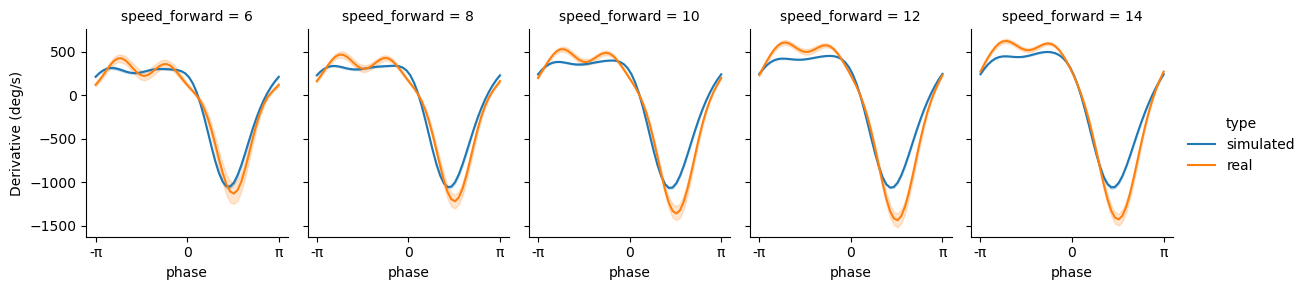

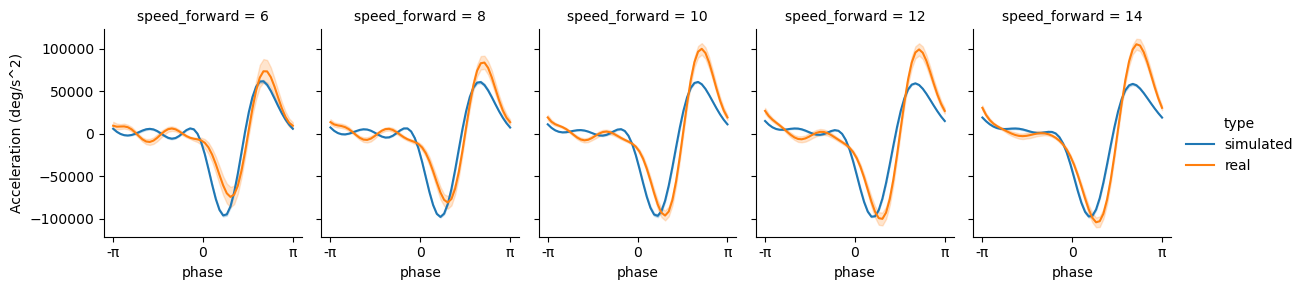

In [36]:
leg = 'L2'
angname = 'B_rot'

dd = fullangf
c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] > 5) & (dd['speed_forward'] < 15) \
    & (dd['angle_name'] == angname) & (dd['leg'] == leg)
g = sns.relplot(data=dd[c], x="phase", y="angle", hue="type",
                estimator=np.mean, err_style='band', errorbar=('ci', 95),
                col="speed_forward", kind="line", height=3, aspect=0.8)
g.set(ylabel="Angle (deg)")
g.set(xticks=[-np.pi, 0, np.pi], xticklabels=["-π", "0", "π"])
plt.savefig('plots/fig2B_phase_angle_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] > 5) & (dd['speed_forward'] < 15) \
    & (dd['angle_name'] == angname) & (dd['leg'] == leg)
g = sns.relplot(data=dd[c], x="phase", y="deriv_units", hue="type",
                estimator=np.mean, err_style='band', errorbar=('ci', 95),
                col="speed_forward", kind="line", height=3, aspect=0.8)
g.set(ylabel="Derivative (deg/s)")
g.set(xticks=[-np.pi, 0, np.pi], xticklabels=["-π", "0", "π"])
plt.savefig('plots/fig2B_phase_deriv_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
    & (dd['speed_forward'] > 5) & (dd['speed_forward'] < 15) \
    & (dd['angle_name'] == angname) & (dd['leg'] == leg)
g = sns.relplot(data=dd[c], x="phase", y="accel_units", hue="type",
                estimator=np.mean, err_style='band', errorbar=('ci', 95),
                col="speed_forward", kind="line", height=3, aspect=0.8)
g.set(ylabel="Acceleration (deg/s^2)")
g.set(xticks=[-np.pi, 0, np.pi], xticklabels=["-π", "0", "π"])
plt.savefig('plots/fig2B_phase_accel_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

### Supplementary plots - all the phase angle plots



not sure if it's worth including these to be honest? There are wayyy to many to show



In [40]:
def circular_mean(x):
    # return np.degrees(stats.circmean(np.radians(x), nan_policy='omit'))
    return np.degrees(np.angle(np.nanmean(np.exp(1j * np.radians(x)))))

def circular_mean_high(x):
    y = np.mod(circular_mean(x), 360)
    if y < 90:
        return y + 360
    else:
        return y

def circular_mean_low(x):
    y = np.mod(circular_mean(x), 360)
    if y > 270:
        return y - 360
    else:
        return y

In [41]:
def circular_ci(x, mean_fn=circular_mean):
    stderr = np.degrees(stats.circstd(np.radians(x), nan_policy='omit')) / np.sqrt(len(x))
    mean = mean_fn(x)
    interval = stderr * 1.96
    return (mean - interval, mean + interval)

In [42]:
fullangf['leg_angle'] = fullangf['leg'] + fullangf['angle_name']

100%|█████████████████████████████████| 20/20 [03:39<00:00, 11.00s/it]


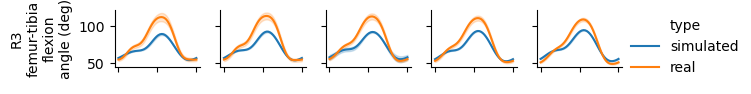

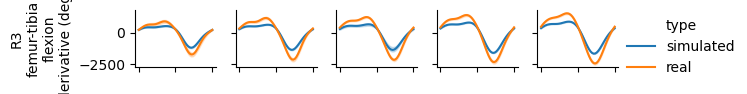

In [43]:
dd = fullangf
for leg_angle in tqdm(dd['leg_angle'].unique(), ncols=70):
# for leg_angle in ['R2B_rot']:
    plt.close('all')

    c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
        & (dd['speed_forward'] > 5) & (dd['speed_forward'] < 15) \
        & (dd['leg_angle'] == leg_angle)
    fancy_name = leg_angle[:2] + '\n' + fancy_angle_names[leg_angle[2:]]

    ddd = dd[c].copy()
    the_mean = circular_mean
    errorbar = circular_ci
    if leg_angle in ['L1A_abduct', 'R3B_rot', 'R2B_rot']:
        the_mean = circular_mean_high
        errorbar = lambda x: circular_ci(x, circular_mean_high)
    elif leg_angle in ['L3B_rot']:
        the_mean = circular_mean_low
        errorbar = lambda x: circular_ci(x, circular_mean_low)

    g = sns.relplot(data=ddd, x="phase", y="angle", hue="type",
                    estimator=the_mean, err_style='band', errorbar=errorbar,
                    col="speed_forward", kind="line", height=1.5, aspect=0.8)
    g.set(ylabel=fancy_name + "\nangle (deg)", title="", xlabel="")
    g.set(xticks=[-np.pi, 0, np.pi], xticklabels=[])
    plt.savefig('plots/suppfig2_phase_angle_{}.pdf'.format(leg_angle), bbox_inches = "tight")

    g = sns.relplot(data=ddd, x="phase", y="deriv_units", hue="type",
                    estimator=np.mean, err_style='band', errorbar=('ci', 95),
                    col="speed_forward", kind="line", height=1.5, aspect=0.8)
    g.set(ylabel=fancy_name + "\nderivative (deg/s)", title="", xlabel="")
    g.set(xticks=[-np.pi, 0, np.pi], xticklabels=[])
    plt.savefig('plots/suppfig2_phase_deriv_{}.pdf'.format(leg_angle), bbox_inches = "tight")

# c = (dd['speed_side'].abs() <= 3) & (dd['speed_rotation'].abs() <= 3) \
#     & (dd['speed_forward'] > 5) & (dd['speed_forward'] < 15) \
#     & (dd['angle_name'] == angname) & (dd['leg'] == leg)
# g = sns.relplot(data=dd[c], x="phase", y="accel_units", hue="type",
#                 estimator=np.mean, err_style='band', errorbar=('ci', 95),
#                 col="speed_forward", kind="line", height=3, aspect=0.8)
# g.set(ylabel="Acceleration (deg/s^2)")
# plt.savefig('plots/fig2B_phase_accel_{}{}.pdf'.format(leg, angname), bbox_inches = "tight")

### Errors across angles



Need to run "Phase angle plots" section above to get the appropriate dataframes.



In [44]:
def circular_mean(x):
    # return np.degrees(stats.circmean(np.radians(x), nan_policy='omit'))
    return np.degrees(np.angle(np.nanmean(np.exp(1j * np.radians(x)))))

In [45]:
columns = ['leg', 'speed_forward', 'speed_rotation', 'speed_side', 'angle_name', 'phase']

ds = []
for var in ['angle', 'deriv', 'accel']:
    print(var)
    if var == 'angle':
        mean_fun = circular_mean
    else:
        mean_fun = np.nanmean
    sd = allangf.groupby(columns)[var].agg(mean_fun)
    rd = realangf.groupby(columns)[var].agg(mean_fun)
    out = sd - rd
    errors = out.reset_index().groupby(columns[:-1])[var]\
                              .agg(lambda x: np.abs(mean_fun(np.abs(x))))

    erange = rd.reset_index().groupby(columns[:-1])[var]\
                             .agg(lambda x: np.max(x) - np.min(x))

    percent_errors = (errors / erange) * 100.0

    errors = errors.reset_index()
    errors[var+'_percent'] = percent_errors.reset_index()[var]
    # errors = errors[~errors[var].isnull()]
    ds.append(errors)

angle_errors = pd.merge(pd.merge(ds[0], ds[1]), ds[2])

fancy_angle_names = {
    'C_flex': 'femur-tibia\nflexion',
    'A_rot': 'coxa\nrotation',
    'A_abduct': 'body-coxa\nflexion',
    'B_flex': 'coxa-femur\nflexion',
    'B_rot': 'femur\nrotation'
}
angle_errors['fancy_angle_name'] = [fancy_angle_names[x] for x in angle_errors['angle_name']]

angle_order = ['body-coxa\nflexion',
               'coxa\nrotation',
               'coxa-femur\nflexion',
               'femur\nrotation',
               'femur-tibia\nflexion']

angle_errors['deriv_units'] = angle_errors['deriv'] * 300.0
angle_errors['accel_units'] = angle_errors['accel'] * 300.0 * 300.0

angle


/tmp/ipykernel_1204414/473549990.py:3: RuntimeWarning: Mean of empty slice
  return np.degrees(np.angle(np.nanmean(np.exp(1j * np.radians(x)))))


deriv


/tmp/ipykernel_1204414/2397220802.py:14: RuntimeWarning: Mean of empty slice
  .agg(lambda x: np.abs(mean_fun(np.abs(x))))


accel


/tmp/ipykernel_1204414/2397220802.py:14: RuntimeWarning: Mean of empty slice
  .agg(lambda x: np.abs(mean_fun(np.abs(x))))


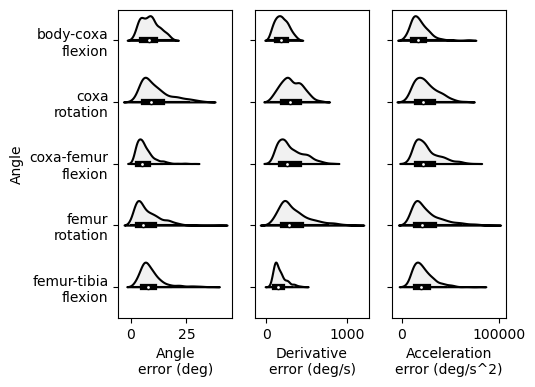

In [46]:
plt.figure(figsize=(5, 4))
plt.subplot(1, 3, 1)
g = sns.violinplot(y='fancy_angle_name', x='angle', data=angle_errors,
                   hue=True, hue_order=[True, False], split=True, orient='h', color='black',
                   order=angle_order)
g.set(ylabel='Angle', xlabel='Angle\nerror (deg)')
g.legend_ = None

plt.subplot(1, 3, 2)
g = sns.violinplot(y='fancy_angle_name', x='deriv_units', data=angle_errors,
                   hue=True, hue_order=[True, False], split=True, orient='h', color='black')
g.set(ylabel='', xlabel='Derivative\nerror (deg/s)', yticklabels=[])
g.legend_ = None

plt.subplot(1, 3, 3)
g = sns.violinplot(y='fancy_angle_name', x='accel_units', data=angle_errors,
                   hue=True, hue_order=[True, False], split=True, orient='h', color='black')
g.set(ylabel='', xlabel='Acceleration\nerror (deg/s^2)', yticklabels=[])
g.legend_ = None

plt.savefig('plots/fig2C_error_raw_horizontal.pdf', bbox_inches = "tight")

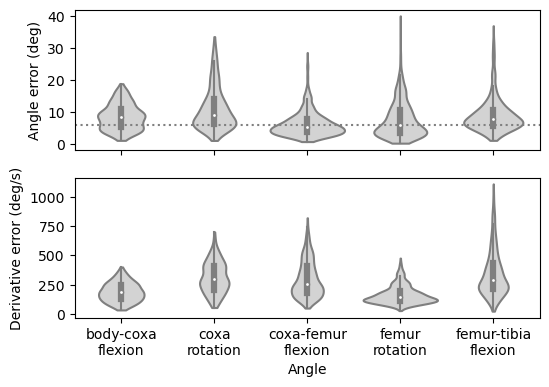

In [47]:
plt.figure(figsize=(6, 4))
ax = plt.subplot(2, 1, 1)
g = sns.violinplot(x='fancy_angle_name', y='angle', data=angle_errors, color='lightgray', cut=0, order=angle_order)
g.set(ylabel='Angle error (deg)', xlabel='')
plt.axhline(5.9, linestyle='dotted', color='gray')
ax.set_xticklabels([])
g.legend_ = None

plt.subplot(2, 1, 2)
g = sns.violinplot(x='fancy_angle_name', y='deriv_units', data=angle_errors, color='lightgray', cut=0, order=angle_order)
g.set(xlabel='Angle', ylabel='Derivative error (deg/s)')
# plt.axhline(5.9, linestyle='dotted', color='black')
g.legend_ = None

plt.savefig('plots/fig2C_error_raw_vertical.pdf', bbox_inches = "tight")

In [48]:
angle_errors.groupby(['leg', 'angle_name'])['angle'].mean()

leg  angle_name
L1   A_abduct       8.563785
     A_rot         14.274670
     B_flex         9.057955
     C_flex        14.502322
L2   B_flex         3.213709
     B_rot          3.530591
     C_flex         8.656140
L3   B_flex         5.151575
     B_rot         12.557957
     C_flex         5.272138
R1   A_abduct       8.448281
     A_rot          7.799010
     B_flex         8.642130
     C_flex         9.913403
R2   B_flex         4.649580
     B_rot          6.020207
     C_flex         7.470407
R3   B_flex         6.607214
     B_rot          7.911936
     C_flex         7.988106
Name: angle, dtype: float64

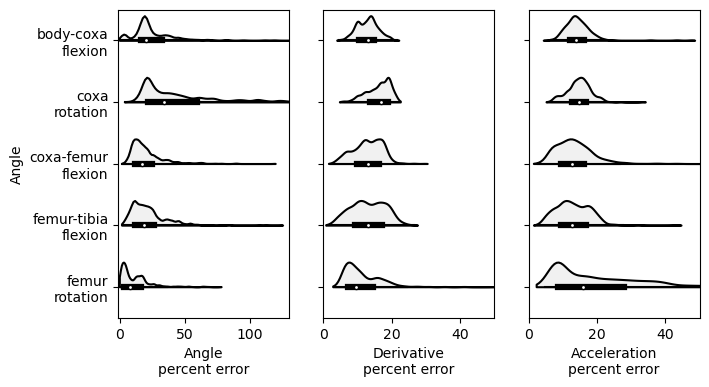

In [49]:
plt.figure(figsize=(2.5*3, 4))
plt.subplot(1, 3, 1)
g = sns.violinplot(y='fancy_angle_name', x='angle_percent', data=angle_errors, cut=0.2, bw=0.1,
                   hue=True, hue_order=[True, False], split=True, orient='h', color='black')
g.set(ylabel='Angle', xlabel='Angle\npercent error', xlim=(-1, 130))
g.legend_ = None

plt.subplot(1, 3, 2)
g = sns.violinplot(y='fancy_angle_name', x='deriv_percent', data=angle_errors, cut=1, bw=0.2,
                   hue=True, hue_order=[True, False], split=True, orient='h', color='black')
g.set(ylabel='', xlabel='Derivative\npercent error', yticklabels=[], xlim=(0, 50))
g.legend_ = None

plt.subplot(1, 3, 3)
g = sns.violinplot(y='fancy_angle_name', x='accel_percent', data=angle_errors, cut=1, bw=0.2,
                   hue=True, hue_order=[True, False], split=True, orient='h', color='black')
g.set(ylabel='', xlabel='Acceleration\npercent error', yticklabels=[], xlim=(0, 50))
g.legend_ = None

plt.savefig('plots/fig2C_error_percent.pdf', bbox_inches = "tight")

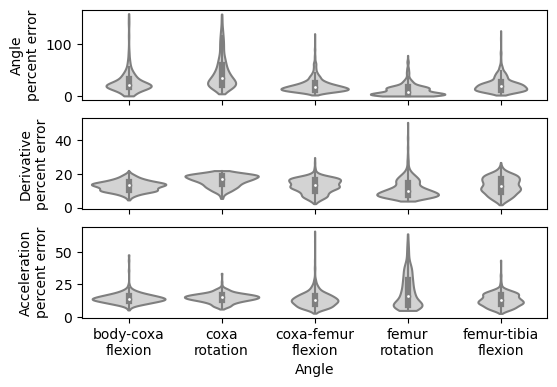

In [50]:
plt.figure(figsize=(6, 4))
ax = plt.subplot(3, 1, 1)
g = sns.violinplot(x='fancy_angle_name', y='angle_percent', data=angle_errors, color='lightgray', cut=0, order=angle_order)
g.set(xlabel='', ylabel='Angle\npercent error')
# plt.axhline(5.9, linestyle='dotted', color='gray')
ax.set_xticklabels([])
g.legend_ = None

ax = plt.subplot(3, 1, 2)
g = sns.violinplot(x='fancy_angle_name', y='deriv_percent', data=angle_errors, color='lightgray', cut=0, order=angle_order)
g.set(xlabel='',ylabel='Derivative\npercent error')
ax.set_xticklabels([])
g.legend_ = None

plt.subplot(3, 1, 3)
g = sns.violinplot(x='fancy_angle_name', y='accel_percent', data=angle_errors, color='lightgray', cut=0, order=angle_order)
g.set(xlabel='Angle', ylabel='Acceleration\npercent error')
g.legend_ = None

plt.savefig('plots/fig2C_error_percent_vertical.pdf', bbox_inches = "tight")

### supplementary errors



I'd like to add the heatmap plots of different speeds. I'm not sure how to convey all the errors at all the different speeds in a compact way.
Perhaps I could break down the violin plot by leg and by speed in two different plots.

-   break down by leg
-   break down by speed

I think that would make more sense than heatmap plots yah.



In [51]:
angle_errors = angle_errors[np.isfinite(angle_errors['angle'])]

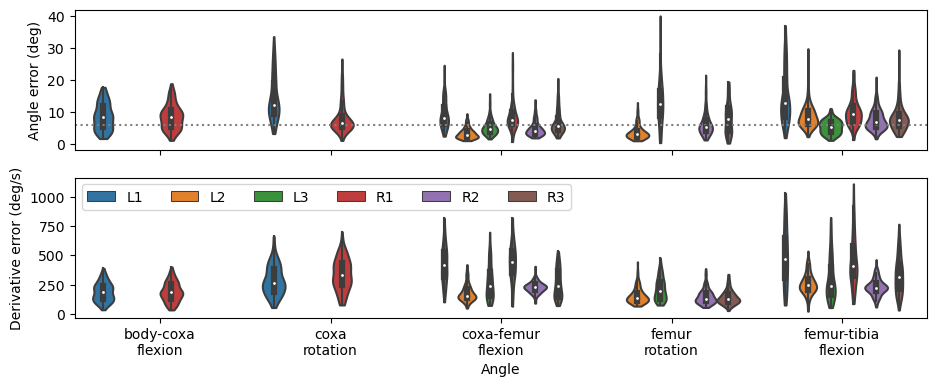

In [52]:
plt.figure(figsize=(11, 4))
ax = plt.subplot(2, 1, 1)
g = sns.violinplot(x='fancy_angle_name', y='angle', hue='leg', data=angle_errors,  cut=0, order=angle_order)
g.set(ylabel='Angle error (deg)', xlabel='')
plt.axhline(5.9, linestyle='dotted', color='gray')
ax.set_xticklabels([])
g.legend_ = None

plt.subplot(2, 1, 2)
g = sns.violinplot(x='fancy_angle_name', y='deriv_units', hue='leg', data=angle_errors, cut=0, order=angle_order)
g.set(xlabel='Angle', ylabel='Derivative error (deg/s)')
# plt.axhline(5.9, linestyle='dotted', color='black')
plt.legend(ncol=6)
# g.legend_ = None

plt.savefig('plots/suppfig2_error_raw_byleg.pdf', bbox_inches = "tight")

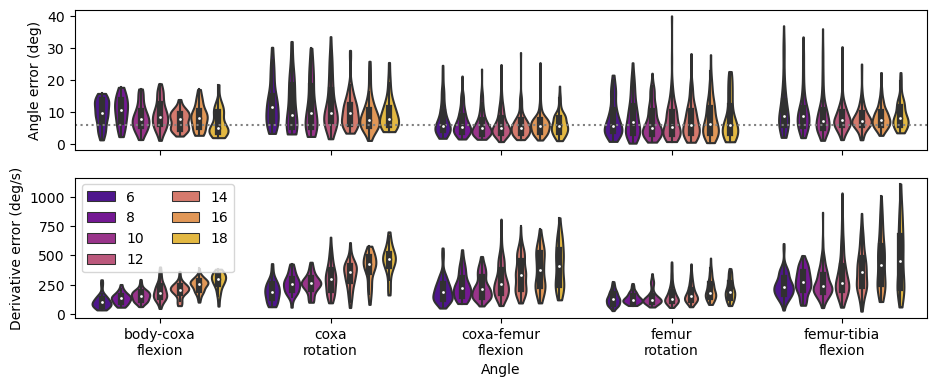

In [53]:
plt.figure(figsize=(11, 4))
ax = plt.subplot(2, 1, 1)
g = sns.violinplot(x='fancy_angle_name', y='angle', hue='speed_forward', data=angle_errors,  cut=0, order=angle_order, palette='plasma')
g.set(ylabel='Angle error (deg)', xlabel='')
plt.axhline(5.9, linestyle='dotted', color='gray')
ax.set_xticklabels([])
g.legend_ = None

plt.subplot(2, 1, 2)
g = sns.violinplot(x='fancy_angle_name', y='deriv_units', hue='speed_forward', data=angle_errors, cut=0, order=angle_order, palette='plasma')
g.set(xlabel='Angle', ylabel='Derivative error (deg/s)')
# plt.axhline(5.9, linestyle='dotted', color='black')
plt.legend(ncol=2)
# g.legend_ = None

plt.savefig('plots/suppfig2_error_raw_speed_forward.pdf', bbox_inches = "tight")

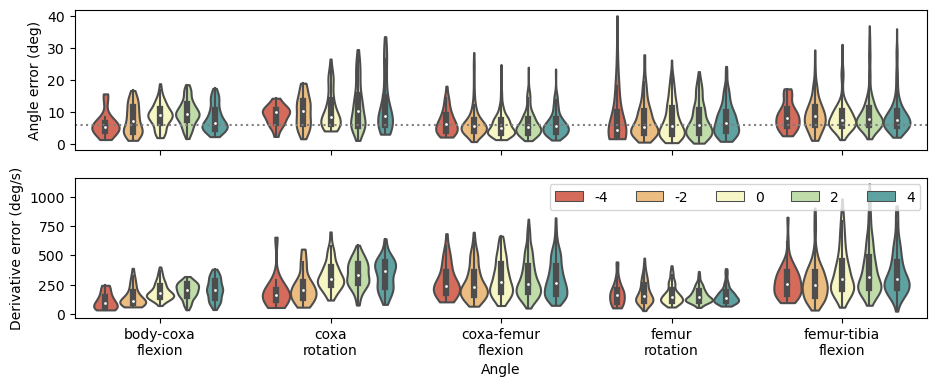

In [54]:
plt.figure(figsize=(11, 4))
ax = plt.subplot(2, 1, 1)
g = sns.violinplot(x='fancy_angle_name', y='angle', hue='speed_side', data=angle_errors,  cut=0, order=angle_order, palette='Spectral')
g.set(ylabel='Angle error (deg)', xlabel='')
plt.axhline(5.9, linestyle='dotted', color='gray')
ax.set_xticklabels([])
g.legend_ = None

plt.subplot(2, 1, 2)
g = sns.violinplot(x='fancy_angle_name', y='deriv_units', hue='speed_side', data=angle_errors, cut=0, order=angle_order, palette='Spectral')
g.set(xlabel='Angle', ylabel='Derivative error (deg/s)')
# plt.axhline(5.9, linestyle='dotted', color='black')
plt.legend(ncol=5)
# g.legend_ = None
plt.savefig('plots/suppfig2_error_raw_speed_side.pdf', bbox_inches = "tight")

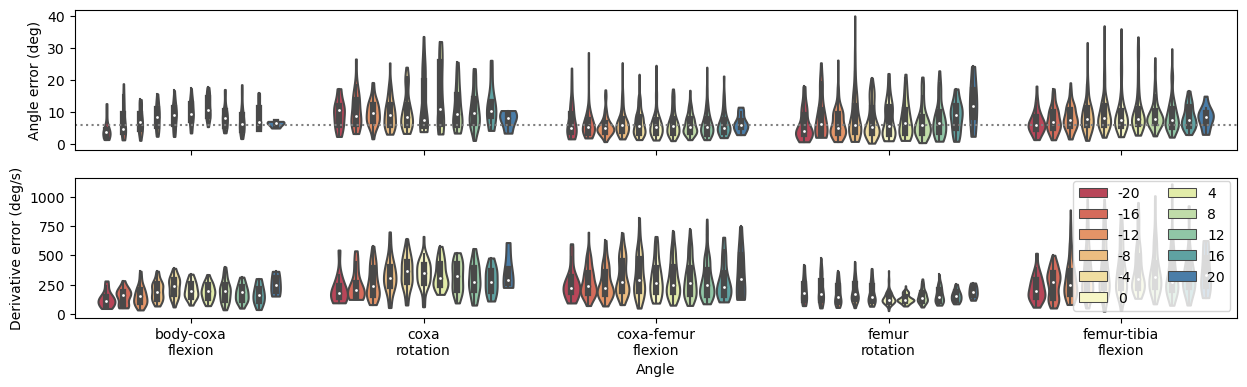

In [55]:
plt.figure(figsize=(15, 4))
ax = plt.subplot(2, 1, 1)
g = sns.violinplot(x='fancy_angle_name', y='angle', hue='speed_rotation', data=angle_errors,  cut=0, order=angle_order, palette='Spectral')
g.set(ylabel='Angle error (deg)', xlabel='')
plt.axhline(5.9, linestyle='dotted', color='gray')
ax.set_xticklabels([])
g.legend_ = None

plt.subplot(2, 1, 2)
g = sns.violinplot(x='fancy_angle_name', y='deriv_units', hue='speed_rotation', data=angle_errors, cut=0, order=angle_order, palette='Spectral')
g.set(xlabel='Angle', ylabel='Derivative error (deg/s)')
# plt.axhline(5.9, linestyle='dotted', color='black')
plt.legend(ncol=2)
# g.legend_ = None

plt.savefig('plots/suppfig2_error_raw_speed_rotation.pdf', bbox_inches = "tight")

### Supplementary - walking speed distributions



In [56]:
speed_names = ['forward velocity', 'rotation velocity', 'side velocity']

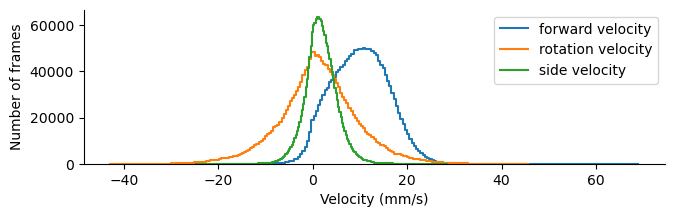

In [57]:
for i in range(3):
    _ = sns.histplot(wd.context[:, i], element='step', fill=False, bins=200,
                     label=speed_names[i])
sns.despine()
plt.legend()
plt.xlabel("Velocity (mm/s)")
plt.ylabel("Number of frames")
plt.savefig('plots/suppfig2_velocities_hist.pdf')

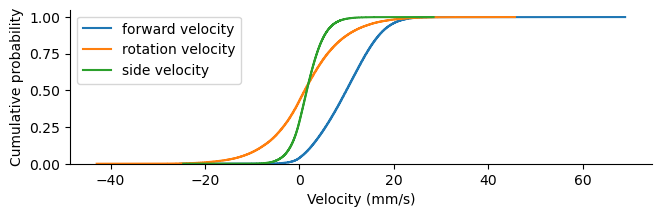

In [58]:
for i in range(3):
    _ = sns.histplot(wd.context[:, i], element='step', fill=False, stat='density',
                     cumulative=True, label=speed_names[i])
plt.legend()
sns.despine()
plt.xlabel("Velocity (mm/s)")
plt.ylabel("Cumulative probability")
plt.savefig('plots/suppfig2_velocities_cdf.pdf')

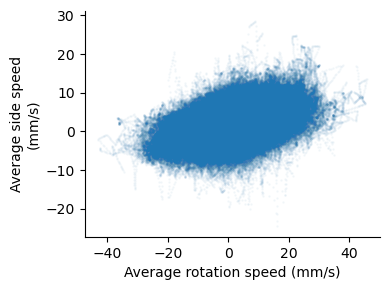

In [59]:
plt.figure(figsize=(4, 3))
plt.scatter(wd.context[:, 1], wd.context[:, 2], s=1, alpha=0.03)
plt.xlabel('Average rotation speed (mm/s)')
plt.ylabel('Average side speed\n(mm/s)')
sns.despine()
plt.tight_layout()
plt.savefig('plots/suppfig2_velocities_rotside_scatter.pdf')
plt.savefig('plots/suppfig2_velocities_rotside_scatter.png')

## Figure 3



### Phase coupling within a leg - phase version



In [60]:
ds = []
for i in trange(len(speeds), ncols=70):
    forward, rot, side = speeds[i]
    d = pd.DataFrame()
    for ix_ang, angname in enumerate(angle_names):
        leg = angname[:2]
        x = np.vstack([angles[i][:, ix_ang],
                       derivs[i][:, ix_ang]]).T
        phase = get_phase(x)
        key = angname
        d[key] = phase
    d['speed_forward'] = forward
    d['speed_rotation'] = rot
    d['speed_side'] = side
    d['type'] = 'simulated'
    ds.append(d)
phases_byleg_sim = pd.concat(ds).reset_index(drop=True)

100%|████████████████████████████| 1540/1540 [00:10<00:00, 140.88it/s]


In [61]:
ds = []
bnums = wd._get_minlen_bnums(400)
for i in trange(len(bnums), ncols=70):
    bnum = bnums[i]
    ww = wd.get_bnum(bnum)
    # mean_speed = np.mean(ww['contexts'], axis=0)
    # forward, rot, side = mean_speed
    d = pd.DataFrame()
    for ix_leg, leg in enumerate(legs):
        for ix_ang, angname in enumerate(wd._angle_names[leg]):
            x = np.vstack([ww['angles'][leg][:, ix_ang],
                           ww['derivatives'][leg][:, ix_ang]]).T
            phase = get_phase(x)
            key = angname
            d[key] = phase
    contexts = ww['contexts']
    d['speed_forward'] = contexts[:, 0]
    d['speed_rotation'] = contexts[:, 1]
    d['speed_side'] = contexts[:, 2]
    d['type'] = 'real'
    ds.append(d)
phases_byleg_real = pd.concat(ds).reset_index(drop=True)

100%|████████████████████████████| 1254/1254 [00:09<00:00, 137.61it/s]


In [62]:
phases_byleg = pd.concat([phases_byleg_sim, phases_byleg_real])

L1
L2
L3
R1
R2
R3


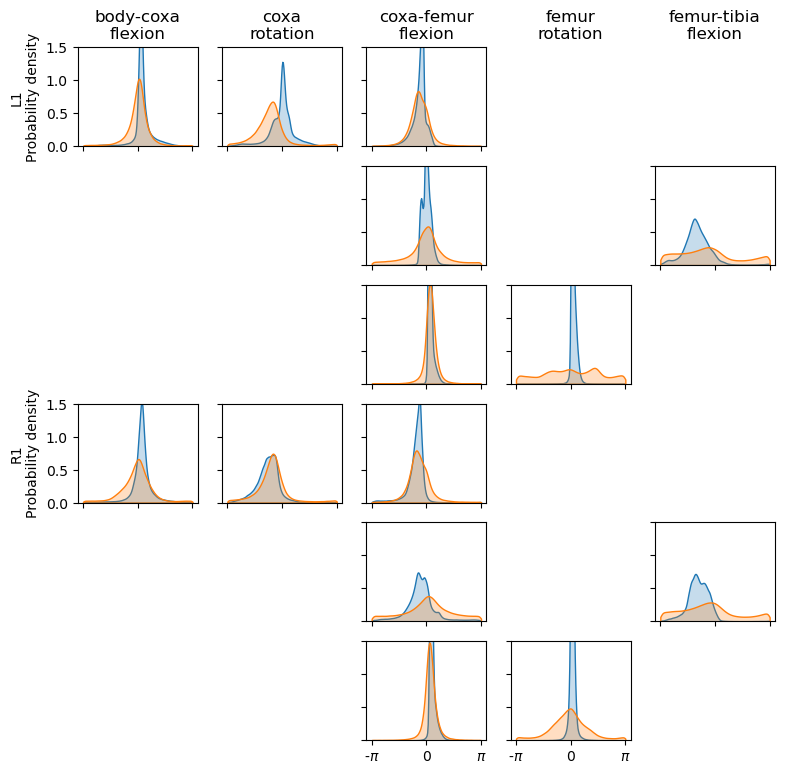

In [63]:
d = phases_byleg
fig, subplots = plt.subplots(6, 5, figsize=(9, 1.5*6))
for ix_leg, leg in enumerate(legs):
    print(leg)
    if leg in ['L2', 'R2']:
        refname = 'B_rot'
    else:
        refname = 'C_flex'
    for ix_ang, angname in enumerate(sorted(angle_names_1leg)):
        ax = subplots[ix_leg][ix_ang]
        if angname == refname:
            if ix_leg == 0:
                ax.set_title(fancy_angle_names[angname])
            ax.set_axis_off()
            continue

        if leg + angname not in d:
            ax.set_axis_off()
        else:
            d = phases_byleg[phases_byleg['type'] == 'simulated']
            if leg == 'R2' or leg+angname in ['R1A_rot', 'R3B_rot']:
                # femur rotation is arbitrary reference, center so that peak is at 0
                vals = np.mod(d[leg + angname] - d[leg + refname], 2*np.pi) - np.pi
            else:
                vals = np.mod(d[leg + angname] - d[leg + refname] + np.pi, 2*np.pi)-np.pi
            sns.kdeplot(vals, cut=0, fill=True, ax=ax)
            d = phases_byleg[phases_byleg['type'] == 'real']
            if leg == 'R2' or leg+angname in ['R1A_rot', 'R3B_rot']:
                # femur rotation is arbitrary reference, center so that peak is at 0
                vals = np.mod(d[leg + angname] - d[leg + refname], 2*np.pi) - np.pi
            else:
                vals = np.mod(d[leg + angname] - d[leg + refname] + np.pi, 2*np.pi)-np.pi
            sns.kdeplot(vals, cut=0, fill=True, ax=ax)
            ax.set_ylim(0, 1.5)

        ax.set_xticks([-np.pi, 0, np.pi])

        if ix_leg == 0:
            ax.set_title(fancy_angle_names[angname])
        if ix_ang == 0:
            ax.set_ylabel(leg + "\nProbability density")
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")
        if ix_leg == 5:
            ax.set_xticklabels(["-$\pi$", "0", "$\pi$"])
        else:
            ax.set_xticklabels([])

plt.savefig("plots/fig3A_phases_withinleg.pdf", bbox_inches = "tight")

### Phase coupling across legs



How to demonstrate the phase coupling across the legs?
I guess we extract the phase from each leg, and compute the difference mod 2 pi?



In [64]:
# compute phase
def get_phase(ang):
    m = np.median(ang, axis=0)
    s = np.std(ang, axis=0)
    s[s == 0] = 1
    dm = (ang - m) / s
    phase = np.arctan2(-dm[:,1], dm[:,0])
    return phase

In [65]:
ds = []
for i in trange(len(speeds), ncols=70):
    d = pd.DataFrame()
    forward, rot, side = speeds[i]
    for ix_leg, leg in enumerate(legs):
        if leg in ['L2', 'R2']:
            phaseang = 'B_rot'
        else:
            phaseang = 'C_flex'
        ix_ang_phase = angle_names.index(leg + phaseang)
        x = np.vstack([angles[i][:, ix_ang_phase],
                       derivs[i][:, ix_ang_phase]]).T
        phase = get_phase(x)
        d['phase_' + leg] = phase
    d['speed_forward'] = forward
    d['speed_rotation'] = rot
    d['speed_side'] = side
    d['type'] = 'simulated'
    ds.append(d)
phased_sim = pd.concat(ds).reset_index(drop=True)

100%|████████████████████████████| 1540/1540 [00:04<00:00, 365.87it/s]


In [66]:
ds = []
bnums = wd._get_minlen_bnums(400)
for i in trange(len(bnums), ncols=70):
    bnum = bnums[i]
    ww = wd.get_bnum(bnum)
    d = pd.DataFrame()
    for ix_leg, leg in enumerate(legs):
        if leg in ['L2', 'R2']:
            phaseang = 'B_rot'
        else:
            phaseang = 'C_flex'
        ix_ang_phase = wd._angle_names[leg].index(leg + phaseang)
        x = np.vstack([ww['angles'][leg][:, ix_ang_phase],
                       ww['derivatives'][leg][:, ix_ang_phase]]).T
        phase = get_phase(x)
        d['phase_' + leg] = phase

    contexts = ww['contexts']
    d['speed_forward_raw'] = contexts[:, 0]
    d['speed_rotation_raw'] = contexts[:, 1]
    d['speed_side_raw'] = contexts[:, 2]
    d['bnum'] = bnum
    d['type'] = 'real'
    ds.append(d)
phased_real = pd.concat(ds).reset_index(drop=True)

phased_real['speed_forward'] = ((phased_real['speed_forward_raw'] + 1) // 2) * 2
phased_real['speed_rotation'] = ((phased_real['speed_rotation_raw'] + 2) // 4) * 4
phased_real['speed_side'] = ((phased_real['speed_side_raw'] + 1) // 2) * 2
phased_real['speed_forward'] = phased_real['speed_forward'].astype('int')
phased_real['speed_rotation'] = phased_real['speed_rotation'].astype('int')
phased_real['speed_side'] = phased_real['speed_side'].astype('int')

100%|████████████████████████████| 1254/1254 [00:04<00:00, 262.77it/s]


In [67]:
phased = pd.concat([phased_sim, phased_real]).reset_index(drop=True)

# Add pi to correct for offset due to the way we compute the phase
phased['phase_L1'] += np.pi
phased['phase_R1'] += np.pi
phased['phase_R2'] += np.pi

In [ ]:
fig, subplots = plt.subplots(6, 6, figsize=(8, 8))
for i, leg_i in enumerate(legs):
    for j, leg_j in enumerate(legs):
        if i == j:
            ax = subplots[i][j]
            ax.text(0.4, 0.4, leg_i, fontsize="xx-large")
            ax.set_axis_off()
            continue
        ax = subplots[i][j]
        d = phased[phased['type'] == 'simulated']
        sns.kdeplot(np.mod(d['phase_'+leg_i] - d['phase_'+leg_j], 2*np.pi), cut=0, bw_method=0.1,
                    fill=True, ax=ax)
        d = phased[phased['type'] == 'real']
        sns.kdeplot(np.mod(d['phase_'+leg_i] - d['phase_'+leg_j], 2*np.pi), cut=0, bw_method=0.1,
                    fill=True, ax=ax)
        ax.set_xlim(0, 2*np.pi)
        ax.set_ylim(0, 0.6)
        ax.set_ylabel("")
        ax.set_xticks([np.pi])
        ax.set_yticks([0.3])
        if i != 5:
            ax.set_xticklabels([])
        if j != 0:
            ax.set_yticklabels([])

fig.savefig('plots/fig3B_phases_legs.pdf', bbox_inches = "tight")

In [ ]:
pp = phasesTG[10]
plt.plot(np.mod(pp[1] - pp[5], 2*np.pi))
# _ = plt.hist(np.mod(2*np.pi - (pp[2] - pp[5]), 2*np.pi), bins=50)

### Phase offsets across speeds



In [ ]:
preal = phased[phased['type'] == 'real'].copy()
preal['speed_forward_4'] = (((preal['speed_forward_raw'] + 2) // 4) * 4).astype('int')

In [ ]:
speeds_forward = [4, 8, 12, 16]
speeds_rotation = [-12, -8, -4, 0, 4, 8, 12]
speeds_side = phased_sim['speed_side'].unique()

In [ ]:
rows = []

for s_f in speeds_forward:
    for s_r in speeds_rotation:
        check = (preal['speed_forward_4'] == s_f) & \
            (preal['speed_rotation'] == s_r)
        if np.sum(check) == 0:
            continue
        sub = preal[check]

        row = {'speed_forward': s_f,
               'speed_rotation': s_r,
               # 'speed_side': s_s,
               'num': len(sub),
               }

        for leg_1 in legs:
            for leg_2 in legs:
                key = 'diff_{}_{}'.format(leg_1, leg_2)
                diff = np.mod(sub['phase_'+leg_1].values -
                              sub['phase_'+leg_2].values, 2*np.pi)
                mm = np.mean(np.exp(1j * diff))
                mean = np.mod(np.angle(mm), 2*np.pi)
                std = np.sqrt(-2 * np.log(np.abs(mm)))
                row[key + '_mean'] = mean
                row[key + '_std'] = std
        rows.append(row)

mean_offsets = pd.DataFrame(rows)

In [ ]:
cmap = plt.get_cmap('plasma')
norm = plt.Normalize(4, 18)
plt.figure(figsize=(6,6))
for i in range(6):
    for j in range(6):
        plt.subplot(6, 6, i*6+j+1)
        if i == j:
            plt.text(0.4, 0.4, legs[i], fontsize="xx-large")
            plt.axis('off')
            continue
        key = 'diff_{}_{}_mean'.format(legs[i], legs[j])
        for s_f in speeds_forward:
            check = (mean_offsets['speed_forward'] == s_f)
            means = np.array(mean_offsets.loc[check, key])
            # fix wrap around
            means[means > np.pi * 1.5] -= 2*np.pi
            if (legs[i], legs[j]) in [('L1', 'R3'), ('R2', 'R3')]:
                means[means < np.pi/2] += 2 * np.pi
            if (legs[i], legs[j]) in [('R3', 'R1'), ('R3', 'L2')]:
                means[means > np.pi] -= 2 * np.pi
            s_r = mean_offsets.loc[check, 'speed_rotation'].values
            ix = np.argsort(s_r)
            plt.plot(s_r[ix], means[ix], color=cmap(norm(s_f)))
        if j != i+1:
            ax = plt.gca()
            ax.set_yticklabels([])
            ax.set_xticklabels([])
        # plt.ylim(-0.75, 0.75)
        plt.ylim(-np.pi / 2, 2*np.pi)
sns.despine()
plt.savefig('plots/suppfig3_phase_offsets_speeds.pdf')